In [1]:
#j'avais travailler dans Cloud Azure avant de le ramaner sur notebook, donc le dataframe s'affiche dans l'environnement Notebook jupiter
df = spark.sql("SELECT * FROM Forecast.Kobas_Daily")
display(df)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 343ebf34-2e7e-4d62-84e2-2969ce950a8b)

Pour connaitre les activités continuelles de ses differents restaurants au quatre coins de l'Angleterre, notre client voulait predire les donnes futures de ses restaurants sur les 3 prochians a venir a partir du dernier jour de la date fournie pour qu'il se preapre en conséquent comment il doit investir dans les mois a suivre. C'etait dans cette optique que le client nous avait fait appel pour mettre en place un modele predictif pour predire cela, un modele robuste. Un truc que j'ai fait et le modele focntionne a plus de 94%.

Vous verrez plus pas les résultats, apres avoir effectuer le pretraitement des données jusqu'a la creation du modèle prédictif.

In [2]:
raw=df.count()
col=len(df.columns)

print("shape: ({},{})".format(raw,col))

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 4, Finished, Available, Finished)

shape: (2076,5)


In [3]:
#effacer les doublons
#df = df.dropDuplicates(["Date"])
#display(df)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 5, Finished, Available, Finished)

In [4]:
#from pyspark.sql.functions import unix_timestamp

#df = df.withColumn("Date", unix_timestamp("Date", "yyyy-MM-dd").cast("timestamp"))
#display(df)


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 6, Finished, Available, Finished)

In [5]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, unix_timestamp

# Convertir les dates en timestamp Unix
df_conv = df.withColumn("DateNumeric", unix_timestamp(col("Date")))

# Supprimer la colonne d'origine
df_conv = df_conv.drop("Date")

# Renommer la nouvelle colonne
df_conv =df_conv.withColumnRenamed("DateNumeric", "Date")

# Afficher les premières lignes du DataFrame avec la colonne numérique de dates
display(df_conv)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 738d7ca9-60b1-4594-ae63-5d84c8b7fc3b)

In [6]:
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import col
#import pyspark.sql.functions as F


# Convertir la colonne de dates en type DateType
#df = df.withColumn("Date", F.to_date(col("Date")))

# Trier les dates du plus ancien au plus récent
#df = df.orderBy(col("Date"))

# Afficher les premières lignes du DataFrame trié
#display( df)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 8, Finished, Available, Finished)

In [7]:
from pyspark.ml.feature import StringIndexer
#supprimer les valeus NULL
df_conv=df_conv.na.drop(subset=["Net_Sales","Covers","Average_Spend_Per_Head"])

# Créer un objet StringIndexer pour la colonne que vous souhaitez encoder
stringIndexer = StringIndexer(inputCol="venue", outputCol="venue_enc")

# Appliquer la transformation sur votre DataFrame
df_conv = stringIndexer.fit(df_conv).transform(df_conv)

# Supprimer la colonne d'origine
df_conv = df_conv.drop("venue")

# Renommer la nouvelle colonne
df_conv =df_conv.withColumnRenamed("venue_enc", "venue")

display(df_conv)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7a99f513-69db-49b2-9cfe-40c48e669d52)

In [8]:
# Import the necessary library for feature vectorization
from pyspark.ml.feature import VectorAssembler

# Train-Test Separation
train_raw1, test_raw1 = df_conv.randomSplit([0.9, 0.1], seed=41)

# Define the feature columns (excluding the target variable 'Exited')
feature_cols1 = [col for col in df.columns if col != "Net_Sales"]
# Correct way to filter out specific columns from the list of columns
#feature_cols1 = [col for col in df_pred.columns if col not in ["Net_Sales", "Covers", "Average_Spend_Per_Head"]]


# Create a VectorAssembler to combine feature columns into a single 'features' column
featurizer1 = VectorAssembler(inputCols=feature_cols1, outputCol="features1")

# Transform the training and testing datasets using the VectorAssembler
train_data1 = featurizer1.transform(train_raw1)["Net_Sales", "features1"]
test_data1 = featurizer1.transform(test_raw1)["Net_Sales", "features1"]

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 10, Finished, Available, Finished)

In [9]:
import logging
 
logging.getLogger('synapse.ml').setLevel(logging.ERROR)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 11, Finished, Available, Finished)

In [10]:
#Configurer MLflow
#nous configurons MLflow pour le suivi des expériences. Nous définissons le nom de l'expérience sur "automl_sample" pour
#organiser les exécution

import mlflow

# Set the MLflow experiment to "automl_sample" and enable automatic logging
mlflow.set_experiment("automl_sample")
mlflow.autolog(exclusive=False)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 12, Finished, Available, Finished)

2024/07/04 04:37:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [11]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

#PREDICTION NET_SALES
# Assuming you have already defined 'train_data' and 'test_data'

with mlflow.start_run(run_name="default") as run:
    # Create a LightGBMClassifier model with specified settings
    model_Net_Sales = LinearRegression(featuresCol="features1", labelCol="Net_Sales")
    
    # Fit the model to the training data
    model_Net_Sales = model_Net_Sales.fit(train_data1)

    # Get the predictions
    predictions1 = model_Net_Sales.transform(test_data1)


    # Évaluer les prédictions en utilisant RMSE
    evaluator_rmse_1 = RegressionEvaluator(labelCol="Net_Sales", predictionCol="prediction", metricName="rmse")
    rmse_1 = evaluator_rmse_1.evaluate(predictions1)


    # Évaluer les prédictions en utilisant R^2
    evaluator_r2_1 = RegressionEvaluator(labelCol="Net_Sales", predictionCol="prediction", metricName="r2")
    r2_1 = evaluator_r2_1.evaluate(predictions1)


     # Loguer la métrique RMSE avec MLflow
    mlflow.log_metric("RMSE", rmse_1)
    mlflow.log_metric("R2", r2_1)

    # Afficher les métriques
    print("RMSE:", rmse_1)
    print("R2:", r2_1)
    print("R2 as percentage:", r2_1 * 100)

    # Sauvegarder le modèle dans MLflow
    mlflow.spark.log_model(model_Net_Sales, "random-forest-regressor-model")

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 13, Finished, Available, Finished)

2024/07/04 04:37:12 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024/07/04 04:37:15 WARNING mlflow.pyspark.ml: Model inputs contain unsupported Spark data types: [StructField('features1', VectorUDT(), True)]. Model signature is not logged.
2024/07/04 04:37:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8uy2o_0a/model, flavor: spark), fall back to return ['pyspark==3.4.1.5.3.20230713']. Set logging level to DEBUG to see the full traceback.
2024/07/04 04:37:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/07/04 04:37:32 WARNING mlflow.data.spark_dataset:

RMSE: 288.1063884837587
R2: 0.9441266835826115
R2 as percentage: 94.41266835826116


In [12]:
#2 PREDICTION COVERS

from pyspark.ml.feature import VectorAssembler

# Train-Test Separation
train_raw2, test_raw2 = df_conv.randomSplit([0.9, 0.1], seed=41)

# Define the feature columns (excluding the target variable 'Exited')
feature_cols2 = [col for col in df.columns if col != "Covers"]

# Create a VectorAssembler to combine feature columns into a single 'features' column
#feature_cols = ["Date", "venue"] #en fonction juste de ces caractéristiques on fera la prediction
featurizer2 = VectorAssembler(inputCols=feature_cols2, outputCol="features2")

# Transform the training and testing datasets using the VectorAssembler
train_data2 = featurizer2.transform(train_raw2)["Covers", "features2"]
test_data2 = featurizer2.transform(test_raw2)["Covers", "features2"]

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 14, Finished, Available, Finished)

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator 
#from synapse.ml.lightgbm import LightGBMClassifier
from pyspark.ml.regression import LinearRegression


# Assuming you have already defined 'train_data' and 'test_data'

with mlflow.start_run(run_name="default") as run:
    # Create a LightGBMClassifier model with specified settings
    model_Covers = LinearRegression(featuresCol="features2", labelCol="Covers")
    
    # Fit the model to the training data
    model_Covers = model_Covers.fit(train_data2)

    # Get the predictions
    predictions2 = model_Covers.transform(test_data2)


    # Évaluer les prédictions en utilisant RMSE
    evaluator_rmse_2 = RegressionEvaluator(labelCol="Covers", predictionCol="prediction", metricName="rmse")
    rmse_2 = evaluator_rmse_2.evaluate(predictions2)


    # Évaluer les prédictions en utilisant R^2
    evaluator_r2_2 = RegressionEvaluator(labelCol="Covers", predictionCol="prediction", metricName="r2")
    r2_2 = evaluator_r2_2.evaluate(predictions2)


     # Loguer la métrique RMSE avec MLflow
    mlflow.log_metric("RMSE", rmse_2)
    mlflow.log_metric("R2", r2_2)

    # Afficher les métriques
    print("RMSE:", rmse_2)
    print("R2:", r2_2)
    print("R2 as percentage:", r2_2 * 100)

    # Sauvegarder le modèle dans MLflow
    mlflow.spark.log_model(model_Covers, "random-forest-regressor-model")

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 15, Finished, Available, Finished)

2024/07/04 04:37:46 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024/07/04 04:37:51 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzr0uh8ej/model, flavor: spark), fall back to return ['pyspark==3.4.1.5.3.20230713']. Set logging level to DEBUG to see the full traceback.
2024/07/04 04:37:54 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024/07/04 04:37:56 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024/07/04 04:38:03 WARNING mlflow.uti

RMSE: 10.782577427841893
R2: 0.9389727723891231
R2 as percentage: 93.89727723891231


In [14]:
#3 PREDICTION Average_Spend_Per_Head

from pyspark.ml.feature import VectorAssembler

# Train-Test Separation
train_raw3, test_raw3 = df_conv.randomSplit([0.9, 0.1], seed=41)

# Define the feature columns (excluding the target variable 'Exited')
feature_cols3 = [col for col in df.columns if col != "Average_Spend_Per_Head"]

# Create a VectorAssembler to combine feature columns into a single 'features' column
featurizer3 = VectorAssembler(inputCols=feature_cols3, outputCol="features3")

# Transform the training and testing datasets using the VectorAssembler
train_data3 = featurizer3.transform(train_raw3)["Average_Spend_Per_Head", "features3"]
test_data3 = featurizer3.transform(test_raw3)["Average_Spend_Per_Head", "features3"]

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 16, Finished, Available, Finished)

In [15]:
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.regression import LinearRegression


# Assuming you have already defined 'train_data' and 'test_data'

with mlflow.start_run(run_name="default") as run:

    # Initialiser un modèle Random Forest
    #model_Average_Spend_Per_Head = RandomForestRegressor(featuresCol="features3", labelCol="Average_Spend_Per_Head")
    # Entraîner le modèle sur les données d'entraînement
    #model_Average_Spend_Per_Head = model_Average_Spend_Per_Head.fit(train_data3)
    
    # Create a LightGBMClassifier model with specified settings
    model_Average_Spend_Per_Head = LinearRegression(featuresCol="features3", labelCol="Average_Spend_Per_Head")
    # Fit the model to the training data
    model_Average_Spend_Per_Head = model_Average_Spend_Per_Head.fit(train_data3)

    # Faire des prédictions sur les données de test
    predictions3 = model_Average_Spend_Per_Head.transform(test_data3)


    # Évaluer les prédictions en utilisant RMSE
    evaluator_rmse_3 = RegressionEvaluator(labelCol="Average_Spend_Per_Head", predictionCol="prediction", metricName="rmse")
    rmse_3 = evaluator_rmse_3.evaluate(predictions3)


    # Évaluer les prédictions en utilisant R^2
    evaluator_r2_3 = RegressionEvaluator(labelCol="Average_Spend_Per_Head", predictionCol="prediction", metricName="r2")
    r2_3 = evaluator_r2_3.evaluate(predictions3)


     # Loguer la métrique RMSE avec MLflow
    mlflow.log_metric("RMSE", rmse_3)
    mlflow.log_metric("R2", r2_3)

    # Afficher les métriques
    print("RMSE:", rmse_3)
    print("R2:", r2_3)
    print("R2 as percentage:", r2_3 * 100)

    # Sauvegarder le modèle dans MLflow
    mlflow.spark.log_model(model_Average_Spend_Per_Head, "random-forest-regressor-model")

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 17, Finished, Available, Finished)

2024/07/04 04:38:08 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024/07/04 04:38:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpt3a6xy2s/model, flavor: spark), fall back to return ['pyspark==3.4.1.5.3.20230713']. Set logging level to DEBUG to see the full traceback.
2024/07/04 04:38:17 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024/07/04 04:38:19 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024/07/04 04:38:26 WARNING mlflow.uti

RMSE: 2.9320333324163164
R2: 0.7072872594816079
R2 as percentage: 70.72872594816079


In [16]:
#Sauvegarde des 3 models

#model_Net_Sales
model_path1 = "Files/Model/netsales"
model_Net_Sales.write().overwrite().save(model_path1)

#model_Covers
model_path2 = "Files/Model/covers"
model_Covers.write().overwrite().save(model_path2)

#model_Average_Spend_Per_Head
model_path3 = "Files/Model/averageSpendPerHead"
model_Average_Spend_Per_Head.write().overwrite().save(model_path3)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 18, Finished, Available, Finished)

In [17]:
df_pred = spark.sql("SELECT * FROM Forecast.Kobas_Daily")

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 19, Finished, Available, Finished)

In [18]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, unix_timestamp
# Convertir les dates en timestamp Unix
df_pred = df_pred.withColumn("DateNumeric", unix_timestamp(col("Date")))

# Supprimer la colonne d'origine
df_pred = df_pred.drop("Date")

# Renommer la nouvelle colonne
df_pred =df_pred.withColumnRenamed("DateNumeric", "Date")
#display(df_pred)


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 20, Finished, Available, Finished)

In [19]:
from pyspark.ml.feature import StringIndexer
#supprimer les valeus NULL
df_pred=df_pred.na.drop(subset=["Net_Sales","Covers","Average_Spend_Per_Head"])

# Créer un objet StringIndexer pour la colonne 'venue'
stringIndexer = StringIndexer(inputCol="venue", outputCol="venue_enc")

# Appliquer la transformation sur votre DataFrame
#df_pred = stringIndexer.fit(df_pred).transform(df_pred)
stringIndexerModel = stringIndexer.fit(df_pred)
df_pred = stringIndexerModel.transform(df_pred)

# Supprimer la colonne d'origine
df_pred = df_pred.drop("venue")

# Renommer la nouvelle colonne
df_pred =df_pred.withColumnRenamed("venue_enc", "venue")

#display(df_pred)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 21, Finished, Available, Finished)

2024/07/04 04:39:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '322cf1b5-aa60-40ba-875d-223f03bf2c1a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


In [20]:
#APPLICATION DU MODEL POUR NET_SALES

from pyspark.ml.regression import LinearRegressionModel



#Charger le modèle enregistré
loaded_model_Net_Sales = LinearRegressionModel.load(model_path1)

# Créer un VectorAssembler pour transformer les nouvelles données
featurizer_new1 = VectorAssembler(inputCols=feature_cols1, outputCol="features1")

# Transformer les nouvelles données
df_pred_transformed1 = featurizer_new1.transform(df_pred)

# Appliquer le modèle chargé pour faire des prédictions sur les nouvelles données
predictions_new1 = loaded_model_Net_Sales.transform(df_pred_transformed1)

# Afficher les prédictions
predictions_new1.select("Date", "venue", "features1", "prediction").show()

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 22, Finished, Available, Finished)

+----------+-----+--------------------+------------------+
|      Date|venue|           features1|        prediction|
+----------+-----+--------------------+------------------+
|1706486400|  1.0|[1.0,1.7064864E9,...| 1752.363722935811|
|1707091200|  1.0|[1.0,1.7070912E9,...|1282.2603854718973|
|1709596800|  1.0|[1.0,1.7095968E9,...|1449.6983131869374|
|1709683200|  1.0|[1.0,1.7096832E9,...| 1562.495629451334|
|1684108800|  1.0|[1.0,1.6841088E9,...|1356.2333398396686|
|1684540800|  1.0|[1.0,1.6845408E9,...|1808.6633668326858|
|1685923200|  1.0|[1.0,1.6859232E9,...|1303.2952398506936|
|1692144000|  1.0|[1.0,1.692144E9,6...| 1362.479679112541|
|1694736000|  1.0|[1.0,1.694736E9,6...|1810.9542671881009|
|1700092800|  1.0|[1.0,1.7000928E9,...|1550.1968021887847|
|1713916800|  1.0|[1.0,1.7139168E9,...|1761.9848966962563|
|1716508800|  1.0|[1.0,1.7165088E9,...|1641.2195534931798|
|1716940800|  1.0|[1.0,1.7169408E9,...|1566.0172289302564|
|1704067200|  1.0|[1.0,1.7040672E9,...| 824.810040030197

In [21]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegressionModel
from pyspark.sql.functions import col, lit, avg, stddev, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

# Encoder la colonne 'Date'

# Charger le modèle enregistré
loaded_model_Net_Sales = LinearRegressionModel.load(model_path1)

# Assembler les fonctionnalités
df_pred = featurizer1.transform(df_pred)


# Extraire les lieux distincts
distinct_venues = df_pred.select("venue").distinct().collect()
venue_ids = [row["venue"] for row in distinct_venues]


# Créer une fonction UDF pour générer des valeurs aléatoires
# Générer des valeurs futures en utilisant des moyennes historiques avec des variations

def generate_random_value(mean, stddev):
    return float(mean + stddev * np.random.randn())

generate_random_value_udf = udf(generate_random_value, DoubleType())


# Préparer une liste pour stocker les résultats de prédiction
predictions_list1 = []

# Générer des données futures et effectuer des prédictions pour chaque lieu distinct
for venue_id in venue_ids:
    venue_df = df_pred.filter(df_pred.venue == venue_id)
    
    # Calculer les moyennes et écarts-types pour le lieu actuel
    historical_avg_covers = venue_df.agg(avg("Covers")).collect()[0][0]
    historical_std_covers = venue_df.agg(stddev("Covers")).collect()[0][0]
    historical_avg_spend = venue_df.agg(avg("Average_Spend_Per_Head")).collect()[0][0]
    historical_std_spend = venue_df.agg(stddev("Average_Spend_Per_Head")).collect()[0][0]
    
    # Créer un DataFrame pour les 60 prochains jours
    last_date = venue_df.agg({"Date": "max"}).collect()[0][0]
    future_dates = [last_date + (86400 * i) for i in range(1, 61)]  # 86400 seconds in a day
    
    future_df1 = pd.DataFrame(future_dates, columns=["Date"])
    future_df_spark1 = spark.createDataFrame(future_df1)
    
    # Ajouter des colonnes avec les valeurs futures
    future_df_spark1 = future_df_spark1.withColumn("Covers", generate_random_value_udf(lit(historical_avg_covers), lit(historical_std_covers)))
    future_df_spark1 = future_df_spark1.withColumn("Average_Spend_Per_Head", generate_random_value_udf(lit(historical_avg_spend), lit(historical_std_spend)))
    future_df_spark1 = future_df_spark1.withColumn("venue", lit(venue_id))
    
    # Assembler les fonctionnalités
    future_df_spark1 = featurizer1.transform(future_df_spark1)
    
    # Prédire les Net_Sales pour les 60 prochains jours pour le lieu actuel
    predictions_future1 = loaded_model_Net_Sales.transform(future_df_spark1)
    
    # Ajouter les prédictions à la liste
    predictions_list1.append(predictions_future1)


# Combiner toutes les prédictions en un seul DataFrame
final_predictions1 = predictions_list1[0]
for pred1 in predictions_list1[1:]:
    final_predictions1 = final_predictions1.union(pred1)

# Afficher les prédictions finales
final_predictions1.select("Date", "venue", "prediction").show()

display(final_predictions1)


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 23, Finished, Available, Finished)

+----------+-----+------------------+
|      Date|venue|        prediction|
+----------+-----+------------------+
|1717372800|  0.0|3132.8198794982854|
|1717459200|  0.0|2611.8861234311125|
|1717545600|  0.0|3932.1219840954273|
|1717632000|  0.0| 1346.839340492672|
|1717718400|  0.0| 2838.641206846717|
|1717804800|  0.0| 2602.280163877307|
|1717891200|  0.0|1979.1324202944834|
|1717977600|  0.0|3133.0630954213802|
|1718064000|  0.0|2612.1293393542073|
|1718150400|  0.0| 3932.365200018523|
|1718236800|  0.0|1347.0825564157672|
|1718323200|  0.0| 2838.884422769812|
|1718409600|  0.0| 2602.523379800402|
|1718496000|  0.0| 1979.375636217579|
|1718582400|  0.0|  2311.53296639148|
|1718668800|  0.0| 2311.567711523351|
|1718755200|  0.0|1763.6599499048898|
|1718841600|  0.0| 2900.855617709499|
|1718928000|  0.0| 2380.291748312793|
|1719014400|  0.0|3127.8956451327685|
+----------+-----+------------------+
only showing top 20 rows



SynapseWidget(Synapse.DataFrame, 75036e6b-cd4a-40a0-895f-8b23c4d48a2a)

In [22]:
#APPLICATION DU MODEL POUR COVERS

from pyspark.ml.regression import LinearRegressionModel



#Charger le modèle enregistré
loaded_model_Covers = LinearRegressionModel.load(model_path2)

# Créer un VectorAssembler pour transformer les nouvelles données
featurizer_new2 = VectorAssembler(inputCols=feature_cols2, outputCol="features2")

# Transformer les nouvelles données
df_pred_transformed2 = featurizer_new2.transform(df_pred)

# Appliquer le modèle chargé pour faire des prédictions sur les nouvelles données
predictions_new2 = loaded_model_Covers.transform(df_pred_transformed2)

# Afficher les prédictions
predictions_new2.select("Date", "venue", "features2", "prediction").show()

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 24, Finished, Available, Finished)

+----------+-----+--------------------+------------------+
|      Date|venue|           features2|        prediction|
+----------+-----+--------------------+------------------+
|1706486400|  1.0|[1.0,1.7064864E9,...| 70.04644199983687|
|1707091200|  1.0|[1.0,1.7070912E9,...| 70.73114263164774|
|1709596800|  1.0|[1.0,1.7095968E9,...| 67.20189791036594|
|1709683200|  1.0|[1.0,1.7096832E9,...| 66.91825248866164|
|1684108800|  1.0|[1.0,1.6841088E9,...| 69.39784710746241|
|1684540800|  1.0|[1.0,1.6845408E9,...|  66.1948494504449|
|1685923200|  1.0|[1.0,1.6859232E9,...| 68.60243916812496|
|1692144000|  1.0|[1.0,1.692144E9,1...| 76.19933791436516|
|1694736000|  1.0|[1.0,1.694736E9,2...| 73.76180313809768|
|1700092800|  1.0|[1.0,1.7000928E9,...|  68.9982389859808|
|1713916800|  1.0|[1.0,1.7139168E9,...| 70.04760329013862|
|1716508800|  1.0|[1.0,1.7165088E9,...| 74.64177996315766|
|1716940800|  1.0|[1.0,1.7169408E9,...|  76.4413347765551|
|1704067200|  1.0|[1.0,1.7040672E9,...| 37.0512333687811

In [23]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegressionModel
from pyspark.sql.functions import col, lit, avg, stddev, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

# Encoder la colonne 'Date'
#Encoder la colonne "venue"

# Charger le modèle enregistré
loaded_model_Covers = LinearRegressionModel.load(model_path2)

# Assembler les fonctionnalités
df_pred = featurizer2.transform(df_pred)


# Extraire les lieux distincts
distinct_venues = df_pred.select("venue").distinct().collect()
venue_ids = [row["venue"] for row in distinct_venues]


# Créer une fonction UDF pour générer des valeurs aléatoires
# Générer des valeurs futures en utilisant des moyennes historiques avec des variations

def generate_random_value(mean, stddev):
    return float(mean + stddev * np.random.randn())

generate_random_value_udf = udf(generate_random_value, DoubleType())


# Préparer une liste pour stocker les résultats de prédiction
predictions_list2 = []

# Générer des données futures et effectuer des prédictions pour chaque lieu distinct
for venue_id in venue_ids:
    venue_df = df_pred.filter(df_pred.venue == venue_id)
    
    # Calculer les moyennes et écarts-types pour le lieu actuel
    historical_avg_net_sales = venue_df.agg(avg("Net_Sales")).collect()[0][0]
    historical_std_net_sales = venue_df.agg(stddev("Net_Sales")).collect()[0][0]
    historical_avg_spend = venue_df.agg(avg("Average_Spend_Per_Head")).collect()[0][0]
    historical_std_spend = venue_df.agg(stddev("Average_Spend_Per_Head")).collect()[0][0]
    
    # Créer un DataFrame pour les 60 prochains jours
    last_date = venue_df.agg({"Date": "max"}).collect()[0][0]
    future_dates = [last_date + (86400 * i) for i in range(1, 61)]  # 86400 seconds in a day
    
    future_df2 = pd.DataFrame(future_dates, columns=["Date"])
    future_df_spark2 = spark.createDataFrame(future_df2)
    
    # Ajouter des colonnes avec les valeurs futures
    future_df_spark2 = future_df_spark2.withColumn("Net_Sales", generate_random_value_udf(lit(historical_avg_net_sales), lit(historical_std_net_sales)))
    future_df_spark2 = future_df_spark2.withColumn("Average_Spend_Per_Head", generate_random_value_udf(lit(historical_avg_spend), lit(historical_std_spend)))
    future_df_spark2 = future_df_spark2.withColumn("venue", lit(venue_id))
    
    # Assembler les fonctionnalités
    future_df_spark2 = featurizer2.transform(future_df_spark2)
    
    # Prédire les Net_Sales pour les 60 prochains jours pour le lieu actuel
    predictions_future2 = loaded_model_Covers.transform(future_df_spark2)
    
    # Ajouter les prédictions à la liste
    predictions_list2.append(predictions_future2)


# Combiner toutes les prédictions en un seul DataFrame
final_predictions2 = predictions_list2[0]
for pred2 in predictions_list2[1:]:
    final_predictions2 = final_predictions2.union(pred2)

# Afficher les prédictions finales
final_predictions2.select("Date", "venue", "prediction").show()

display(final_predictions2)


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 25, Finished, Available, Finished)

+----------+-----+------------------+
|      Date|venue|        prediction|
+----------+-----+------------------+
|1717372800|  0.0|149.50332585239636|
|1717459200|  0.0| 47.82156213172459|
|1717545600|  0.0|21.202683579273696|
|1717632000|  0.0|115.53982611674377|
|1717718400|  0.0|57.191210491818396|
|1717804800|  0.0| 127.2089500534215|
|1717891200|  0.0| 88.34000442378999|
|1717977600|  0.0| 71.16338022097236|
|1718064000|  0.0| 132.6828971764475|
|1718150400|  0.0|57.268548402240285|
|1718236800|  0.0|111.71008859261369|
|1718323200|  0.0| 54.99002445902933|
|1718409600|  0.0| 24.56170408354521|
|1718496000|  0.0|149.46538153626236|
|1718582400|  0.0| 47.78361781559059|
|1718668800|  0.0|102.27474906710987|
|1718755200|  0.0| 43.05967675047566|
|1718841600|  0.0| 78.97487630673763|
|1718928000|  0.0|119.55255910577404|
|1719014400|  0.0| 96.27691936032352|
+----------+-----+------------------+
only showing top 20 rows



SynapseWidget(Synapse.DataFrame, ba57483c-3972-42c1-90ec-2e42b4c82399)

In [24]:
#APPLICATION DU MODEL POUR COVERS

from pyspark.ml.regression import LinearRegressionModel



#Charger le modèle enregistré
loaded_model_Average_Spend_Per_Head = LinearRegressionModel.load(model_path3)

# Créer un VectorAssembler pour transformer les nouvelles données
#feature_cols = ["Date", "venue"]
featurizer_new3 = VectorAssembler(inputCols=feature_cols3, outputCol="features3")


# Transformer les nouvelles données
df_pred_transformed3 = featurizer_new3.transform(df_pred)

# Appliquer le modèle chargé pour faire des prédictions sur les nouvelles données
predictions_new3 = loaded_model_Average_Spend_Per_Head.transform(df_pred_transformed3)

# Afficher les prédictions
predictions_new3.select("Date", "venue", "features3", "prediction").show()

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 26, Finished, Available, Finished)

+----------+-----+--------------------+------------------+
|      Date|venue|           features3|        prediction|
+----------+-----+--------------------+------------------+
|1706486400|  1.0|[1.0,1.7064864E9,...|31.247636488146746|
|1707091200|  1.0|[1.0,1.7070912E9,...|27.165713953802033|
|1709596800|  1.0|[1.0,1.7095968E9,...| 27.92667192675038|
|1709683200|  1.0|[1.0,1.7096832E9,...|28.886034465192672|
|1684108800|  1.0|[1.0,1.6841088E9,...|26.628286233152714|
|1684540800|  1.0|[1.0,1.6845408E9,...|  29.9780675371369|
|1685923200|  1.0|[1.0,1.6859232E9,...| 26.02405812538877|
|1692144000|  1.0|[1.0,1.692144E9,1...|28.646344913856275|
|1694736000|  1.0|[1.0,1.694736E9,2...|32.229315336698654|
|1700092800|  1.0|[1.0,1.7000928E9,...|28.909726094649137|
|1713916800|  1.0|[1.0,1.7139168E9,...| 31.62172716251471|
|1716508800|  1.0|[1.0,1.7165088E9,...| 31.73992268377473|
|1716940800|  1.0|[1.0,1.7169408E9,...|31.510247829876313|
|1704067200|  1.0|[1.0,1.7040672E9,...| 29.2951311044504

In [25]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegressionModel
from pyspark.sql.functions import col, lit, avg, stddev, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

# Encoder la colonne 'Date'
#Encoder la colonne "venue"

# Charger le modèle enregistré
loaded_model_Average_Spend_Per_Head = LinearRegressionModel.load(model_path3)

# Assembler les fonctionnalités
df_pred = featurizer3.transform(df_pred)


# Extraire les lieux distincts
distinct_venues = df_pred.select("venue").distinct().collect()
venue_ids = [row["venue"] for row in distinct_venues]


# Créer une fonction UDF pour générer des valeurs aléatoires
# Générer des valeurs futures en utilisant des moyennes historiques avec des variations

def generate_random_value(mean, stddev):
    return float(mean + stddev * np.random.randn())

generate_random_value_udf = udf(generate_random_value, DoubleType())


# Préparer une liste pour stocker les résultats de prédiction
predictions_list3 = []

# Générer des données futures et effectuer des prédictions pour chaque lieu distinct
for venue_id in venue_ids:
    venue_df = df_pred.filter(df_pred.venue == venue_id)
    
    # Calculer les moyennes et écarts-types pour le lieu actuel
    historical_avg_net_sales = venue_df.agg(avg("Net_Sales")).collect()[0][0]
    historical_std_net_sales = venue_df.agg(stddev("Net_Sales")).collect()[0][0]
    historical_avg_covers = venue_df.agg(avg("Covers")).collect()[0][0]
    historical_std_covers = venue_df.agg(stddev("Covers")).collect()[0][0]
    
    # Créer un DataFrame pour les 60 prochains jours
    last_date = venue_df.agg({"Date": "max"}).collect()[0][0]
    future_dates = [last_date + (86400 * i) for i in range(1, 61)]  # 86400 seconds in a day
    
    future_df3 = pd.DataFrame(future_dates, columns=["Date"])
    future_df_spark3 = spark.createDataFrame(future_df3)
    
    # Ajouter des colonnes avec les valeurs futures
    future_df_spark3 = future_df_spark3.withColumn("Net_Sales", generate_random_value_udf(lit(historical_avg_net_sales), lit(historical_std_net_sales)))
    future_df_spark3 = future_df_spark3.withColumn("Covers", generate_random_value_udf(lit(historical_avg_covers), lit(historical_std_covers)))
    future_df_spark3 = future_df_spark3.withColumn("venue", lit(venue_id))
    
    # Assembler les fonctionnalités
    future_df_spark3 = featurizer3.transform(future_df_spark3)
    
    # Prédire les Net_Sales pour les 60 prochains jours pour le lieu actuel
    predictions_future3 = loaded_model_Average_Spend_Per_Head.transform(future_df_spark3)
    
    # Ajouter les prédictions à la liste
    predictions_list3.append(predictions_future3)


# Combiner toutes les prédictions en un seul DataFrame
final_predictions3 = predictions_list3[0]
for pred3 in predictions_list3[1:]:
    final_predictions3 = final_predictions3.union(pred3)

# Afficher les prédictions finales
final_predictions3.select("Date", "venue", "prediction").show()

display(final_predictions3)


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 27, Finished, Available, Finished)

+----------+-----+------------------+
|      Date|venue|        prediction|
+----------+-----+------------------+
|1717372800|  0.0| 47.32066317158586|
|1717459200|  0.0| 31.66509442956498|
|1717545600|  0.0| 33.42792944378796|
|1717632000|  0.0|15.669718222579561|
|1717718400|  0.0|  6.76435232889844|
|1717804800|  0.0| 31.37024343321162|
|1717891200|  0.0|40.693310791274826|
|1717977600|  0.0|45.307412303025885|
|1718064000|  0.0|20.006240195992866|
|1718150400|  0.0| 19.84085797415144|
|1718236800|  0.0|18.393999525356357|
|1718323200|  0.0|34.852365255227085|
|1718409600|  0.0| 43.02609364764179|
|1718496000|  0.0| 7.971192473161921|
|1718582400|  0.0| 44.25348545467098|
|1718668800|  0.0| 40.71974402380148|
|1718755200|  0.0|29.587259320814262|
|1718841600|  0.0|38.424430737601796|
|1718928000|  0.0|26.360703377708774|
|1719014400|  0.0|31.679988004478076|
+----------+-----+------------------+
only showing top 20 rows



SynapseWidget(Synapse.DataFrame, eaff0f12-8332-4e25-9d32-1eb1da714268)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 28, Finished, Available, Finished)

2024/07/04 04:40:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.


0   2024-01-29
1   2024-02-05
2   2024-03-05
3   2024-03-06
4   2023-05-15
Name: Date, dtype: datetime64[ns]


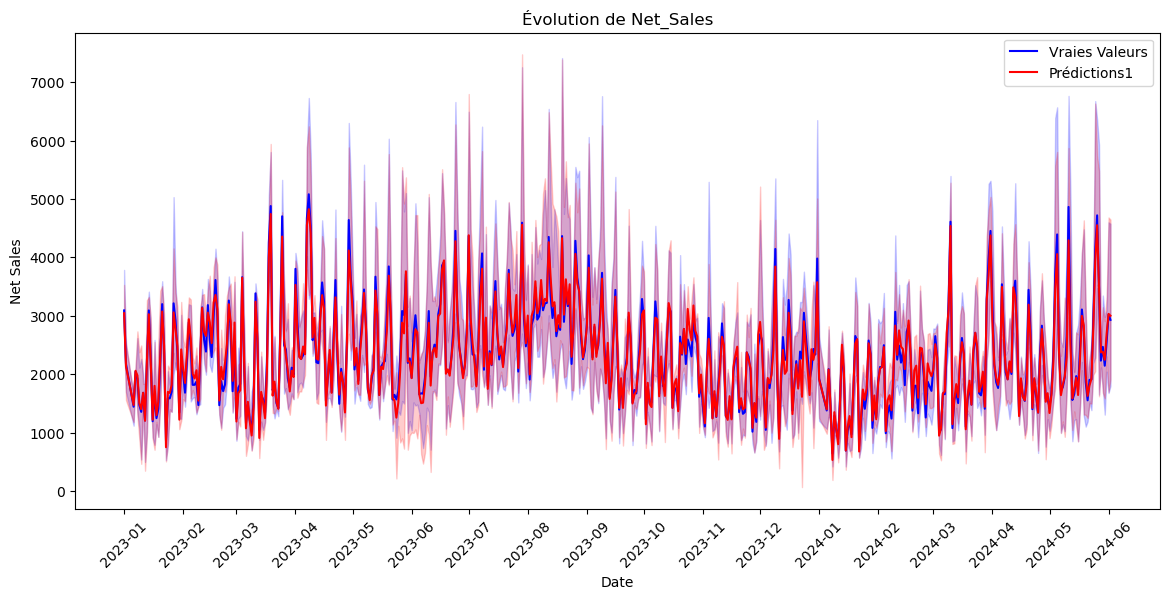

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import from_unixtime
import matplotlib.dates as mdates
from pyspark.sql.functions import to_date



# Reconvertir les valeurs numériques en format de date
predictions_new1 = predictions_new1.withColumn("Date", from_unixtime(predictions_new1["Date"], format="yyyy-MM-dd"))

# Convertir la colonne Date en type Date
predictions_new1 = predictions_new1.withColumn("Date", to_date(predictions_new1["Date"], "yyyy-MM-dd"))

predictions_new11 = predictions_new1.toPandas()

#Je m'assure que les dates sont en format datetime
predictions_new11['Date'] = pd.to_datetime(predictions_new11['Date'], format='%Y-%m-%d')

# Vérifiez le format des dates
print(predictions_new11['Date'].head())

# Tracer les données réelles et prédites pour Average_Spend_Per_Head en fonction de la date
plt.figure(figsize=(14, 7))

# Plot des valeurs réelles
sns.lineplot(x='Date', y='Net_Sales', data=predictions_new11, label='Vraies Valeurs', color='blue')

# Plot des prédictions
sns.lineplot(x='Date', y='prediction', data=predictions_new11, label='Prédictions1', color='red')

plt.title('Évolution de Net_Sales')
plt.xlabel('Date')
plt.ylabel('Net Sales')
plt.legend()
plt.xticks(rotation=45)

# Formater les dates pour qu'elles soient plus lisibles
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Affiche une étiquette par mois
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.subplots_adjust(bottom=0.2)  # Ajustez ce paramètre selon vos besoins pour éviter le chevauchement

plt.show()



StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 29, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


0   2024-01-29
1   2024-02-05
2   2024-03-05
3   2024-03-06
4   2023-05-15
Name: Date, dtype: datetime64[ns]


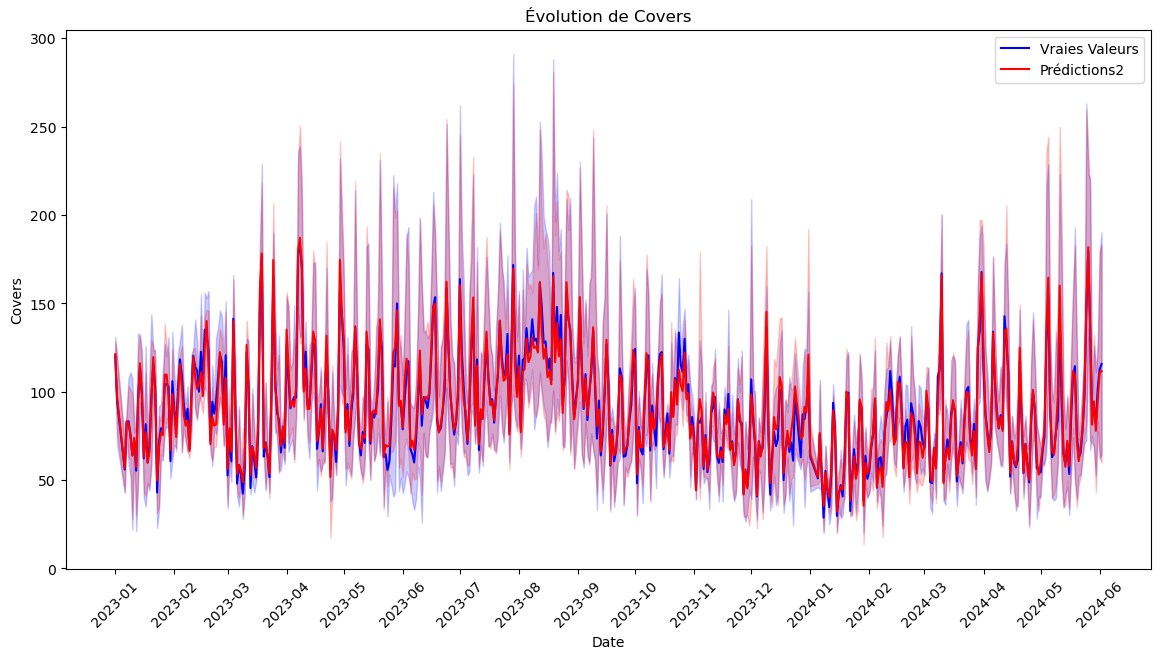

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import from_unixtime

# Reconvertir les valeurs numériques en format de date
predictions_new2 = predictions_new2.withColumn("Date", from_unixtime(predictions_new2["Date"], format="yyyy-MM-dd"))

predictions_new1 = predictions_new1.withColumn("Date", to_date(predictions_new1["Date"], "yyyy-MM-dd"))

predictions_new22 = predictions_new2.toPandas()

#Je m'assure que les dates sont en format datetime
predictions_new22['Date'] = pd.to_datetime(predictions_new22['Date'], format='%Y-%m-%d')

# Vérifiez le format des dates
print(predictions_new22['Date'].head())

# Tracer les données réelles et prédites pour Average_Spend_Per_Head en fonction de la date
plt.figure(figsize=(14, 7))

# Plot des valeurs réelles
sns.lineplot(x='Date', y='Covers', data=predictions_new22, label='Vraies Valeurs', color='blue')

# Plot des prédictions
sns.lineplot(x='Date', y='prediction', data=predictions_new22, label='Prédictions2', color='red')

plt.title('Évolution de Covers')
plt.xlabel('Date')
plt.ylabel('Covers')
plt.legend()
plt.xticks(rotation=45)

# Formater les dates pour qu'elles soient plus lisibles
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Affiche une étiquette par mois
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 30, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


0   2024-01-29
1   2024-02-05
2   2024-03-05
3   2024-03-06
4   2023-05-15
Name: Date, dtype: datetime64[ns]


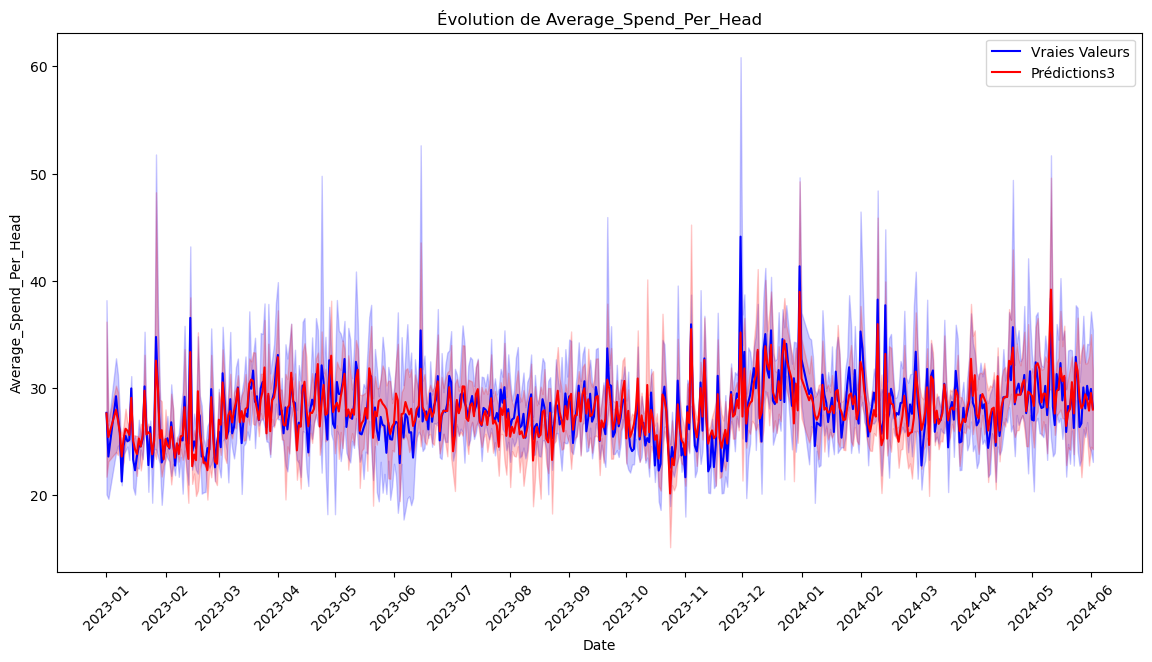

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import from_unixtime

# Reconvertir les valeurs numériques en format de date
predictions_new3 = predictions_new3.withColumn("Date", from_unixtime(predictions_new3["Date"], format="yyyy-MM-dd"))
# Convertir la colonne Date en type Date
predictions_new1 = predictions_new1.withColumn("Date", to_date(predictions_new1["Date"], "yyyy-MM-dd"))

predictions_new33 = predictions_new3.toPandas()

#Je m'assure que les dates sont en format datetime
predictions_new33['Date'] = pd.to_datetime(predictions_new33['Date'], format='%Y-%m-%d')

# Vérifiez le format des dates
print(predictions_new33['Date'].head())

# Tracer les données réelles et prédites pour Average_Spend_Per_Head en fonction de la date
plt.figure(figsize=(14, 7))

# Plot des valeurs réelles
sns.lineplot(x='Date', y='Average_Spend_Per_Head', data=predictions_new33, label='Vraies Valeurs', color='blue')

# Plot des prédictions
sns.lineplot(x='Date', y='prediction', data=predictions_new33, label='Prédictions3', color='red')

plt.title('Évolution de Average_Spend_Per_Head')
plt.xlabel('Date')
plt.ylabel('Average_Spend_Per_Head')
plt.legend()
plt.xticks(rotation=45)

# Formater les dates pour qu'elles soient plus lisibles
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Affiche une étiquette par mois
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

In [29]:
#display(predictions_new1)
#display(predictions_new2)
#display(predictions_new3)
#la conversion en format originel de la Date a marché

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 31, Finished, Available, Finished)

In [30]:
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import to_date

#Conversion des futur prediction en leur format originel
final_predictions1 = final_predictions1.withColumn("Date", from_unixtime(final_predictions1["Date"], format="yyyy-MM-dd"))
# Convertir la colonne Date en type Date
final_predictions1 = final_predictions1.withColumn("Date", to_date(final_predictions1["Date"], "yyyy-MM-dd"))

final_predictions2 = final_predictions2.withColumn("Date", from_unixtime(final_predictions2["Date"], format="yyyy-MM-dd"))
final_predictions2 = final_predictions2.withColumn("Date", to_date(final_predictions2["Date"], "yyyy-MM-dd"))

final_predictions3 = final_predictions3.withColumn("Date", from_unixtime(final_predictions3["Date"], format="yyyy-MM-dd"))
final_predictions3 = final_predictions3.withColumn("Date", to_date(final_predictions3["Date"], "yyyy-MM-dd"))


display(final_predictions1)


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 32, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f4945e75-e879-44de-b3ef-65a736c4db1d)

In [31]:
#Convertion de la colonne DATE en son format originel
#from pyspark.sql.functions import from_unixtime

# Reconvertir les valeurs numériques en format de date
#predictions_new1 = predictions_new1.withColumn("Date", from_unixtime(predictions_new1["Date"], format="yyyy-MM-dd"))

# Afficher les premières lignes pour vérification
#predictions_new1.show()
#display(predictions_new1)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 33, Finished, Available, Finished)

In [32]:
#Maintenant je vais reconvertir la colonne des villes en son formart Strinf Originel que j'avais converti en numérique pour l'entraînement du model
from pyspark.ml.feature import IndexToString
# Inversion de l'indexation de la colonne 'Venue'

#stringIndexer = StringIndexer(inputCol="venue", outputCol="venue_enc")
#stringIndexerModel = stringIndexer.fit(df_pred)

converterFuture1= IndexToString(inputCol="venue", outputCol="venueOrig")
converterFuture1.setLabels(stringIndexerModel.labels)
final_predictions1= converterFuture1.transform(final_predictions1)

#i gonna drop the Col 
final_predictions1= final_predictions1.drop("features1", "venue","Net_Sales","Covers","Average_Spend_Per_Head")
#i gonna rename venueOrigin into venue
final_predictions1=final_predictions1.withColumnRenamed("venueOrig", "venue")\
                                    .withColumnRenamed("prediction", "Net_Sales")

display(final_predictions1)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 34, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a19aefde-e0ec-4ad3-bee7-38db3b60a031)

In [33]:
from pyspark.ml.feature import IndexToString

converterFuture2= IndexToString(inputCol="venue", outputCol="venueOrig")
converterFuture2.setLabels(stringIndexerModel.labels)
final_predictions2= converterFuture2.transform(final_predictions2)

#i gonna drop the Col 
final_predictions2= final_predictions2.drop("features2", "venue","Net_Sales","Covers","Average_Spend_Per_Head")
#i gonna rename venueOrigin into venue
final_predictions2=final_predictions2.withColumnRenamed("venueOrig", "venue")\
                                    .withColumnRenamed("prediction", "Covers")

display(final_predictions2)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 35, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, e38362f9-009a-45d2-8866-4e93e83867f1)

In [34]:
from pyspark.ml.feature import IndexToString

converterFuture3= IndexToString(inputCol="venue", outputCol="venueOrig")
converterFuture3.setLabels(stringIndexerModel.labels)
final_predictions3= converterFuture3.transform(final_predictions3)

#i gonna drop the Col 
final_predictions3= final_predictions3.drop("features3", "venue","Net_Sales","Covers","Average_Spend_Per_Head")
#i gonna rename venueOrigin into venue
final_predictions3=final_predictions3.withColumnRenamed("venueOrig", "venue")\
                                    .withColumnRenamed("prediction", "Average_Spend_Per_Head")

display(final_predictions3)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 36, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 947055f4-424b-4e32-99f8-6b88d377e1d6)

In [36]:
#je vais ajouter maintenant toutes les predictions
# Sélection les colonnes requises de chaque table
table2_selectFutur = final_predictions2.select("Date", "Covers", "venue")
table3_selectFutur = final_predictions3.select("Date", "Average_Spend_Per_Head", "venue")

# Rejoignez les tables sur les colonnes "Date" et "venue"
merged_tableFutur = final_predictions1.join(table2_selectFutur, ['venue', 'Date'], 'left') \
                     .join(table3_selectFutur, ['venue', 'Date'], 'left')


# Affichez les 5 premières lignes de la table fusionnée
merged_tableFutur.show(5)
#TablePredictFutur=merged_tableFutur

display(merged_tableFutur)

StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 38, Finished, Available, Finished)

+---------------+----------+------------------+------------------+----------------------+
|          venue|      Date|         Net_Sales|            Covers|Average_Spend_Per_Head|
+---------------+----------+------------------+------------------+----------------------+
|81 Beach Street|2024-06-03|1689.2080522064243|  49.0145766684592|     29.12924545564914|
|81 Beach Street|2024-06-04| 1907.140998803242|19.959815490142304|    34.761528170414124|
|81 Beach Street|2024-06-05| 2997.157430254776| 80.12419686530032|    26.502979151246322|
|81 Beach Street|2024-06-06|1605.0952344513453|  85.3780264978365|    26.349622433176506|
|81 Beach Street|2024-06-07| 1483.080478103811|61.945219864561565|     4.270801348600088|
+---------------+----------+------------------+------------------+----------------------+
only showing top 5 rows



SynapseWidget(Synapse.DataFrame, 019a46d0-bae2-4f67-af42-be03828183f2)

SynapseWidget(Synapse.DataFrame, 5880a4fa-1c48-4f58-85d1-068153e0f32a)

In [37]:
#Save table
#TablePredict.write.mode("overwrite").format("delta").saveAsTable("kobas_forecast")
#TablePredictFutur.write.mode("overwrite").format("delta").saveAsTable("kobas_forecast")
merged_tableFutur.write.mode("overwrite").format("delta").saveAsTable("kobas_forecast")


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 39, Finished, Available, Finished)

In [39]:
import pandas as pd

# Sélectionner les colonnes nécessaires et convertir en DataFrame Pandas
net_sales_data = merged_tableFutur.select("Date", "venue", "Net_Sales").toPandas()

# Convertir la colonne 'Date' en type datetime
net_sales_data['Date'] = pd.to_datetime(net_sales_data['Date'])

# Afficher les premières lignes du DataFrame Pandas
net_sales_data.head()


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 41, Finished, Available, Finished)

,Date,venue,Net_Sales
0,2024-06-03,81 Beach Street,3132.819879
1,2024-06-04,81 Beach Street,2611.886123
2,2024-06-05,81 Beach Street,3932.121984
3,2024-06-06,81 Beach Street,1346.839340
4,2024-06-07,81 Beach Street,2838.641207


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 42, Finished, Available, Finished)

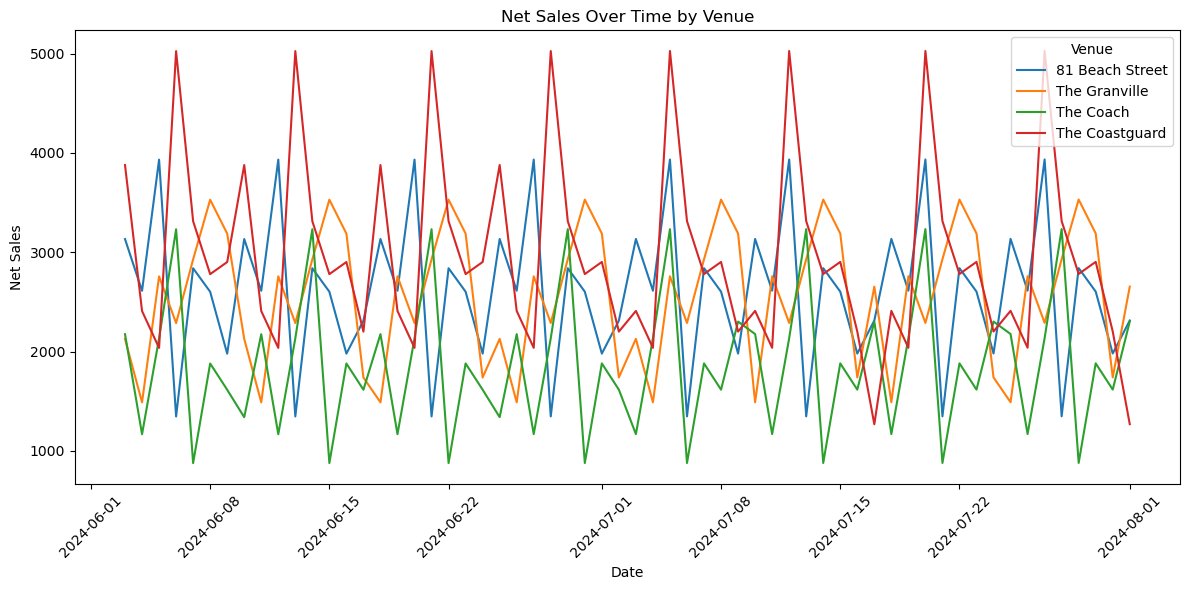

In [40]:
import matplotlib.pyplot as plt

# Tracer Net_Sales en fonction de la Date
plt.figure(figsize=(12, 6))
for venue in net_sales_data['venue'].unique():
    venue_data = net_sales_data[net_sales_data['venue'] == venue]
    plt.plot(venue_data['Date'], venue_data['Net_Sales'], label=venue)

plt.xlabel('Date')
plt.ylabel('Net Sales')
plt.title('Net Sales Over Time by Venue')
plt.legend(title='Venue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 45, Finished, Available, Finished)

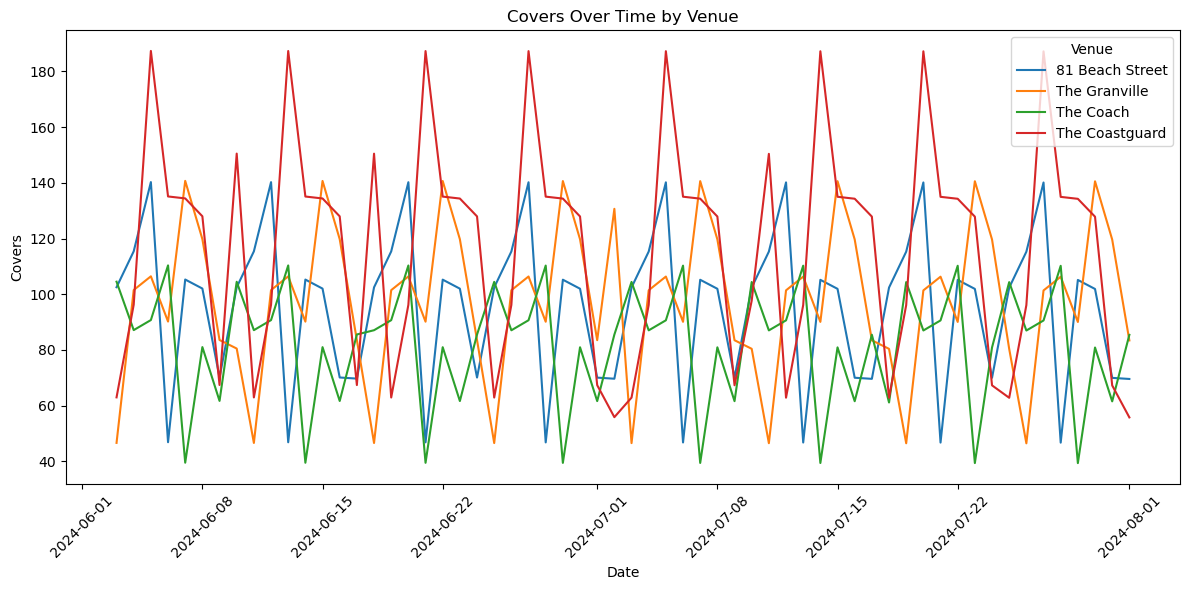

In [43]:
# Sélectionner les colonnes nécessaires et convertir en DataFrame Pandas
covers_data = merged_tableFutur.select("Date", "venue", "Covers").toPandas()

# Convertir la colonne 'Date' en type datetime
covers_data['Date'] = pd.to_datetime(covers_data['Date'])

# Tracer Net_Sales en fonction de la Date
plt.figure(figsize=(12, 6))
for venue in net_sales_data['venue'].unique():
    venue_data = covers_data[covers_data['venue'] == venue]
    plt.plot(venue_data['Date'], venue_data['Covers'], label=venue)

plt.xlabel('Date')
plt.ylabel('Covers')
plt.title('Covers Over Time by Venue')
plt.legend(title='Venue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 48, Finished, Available, Finished)

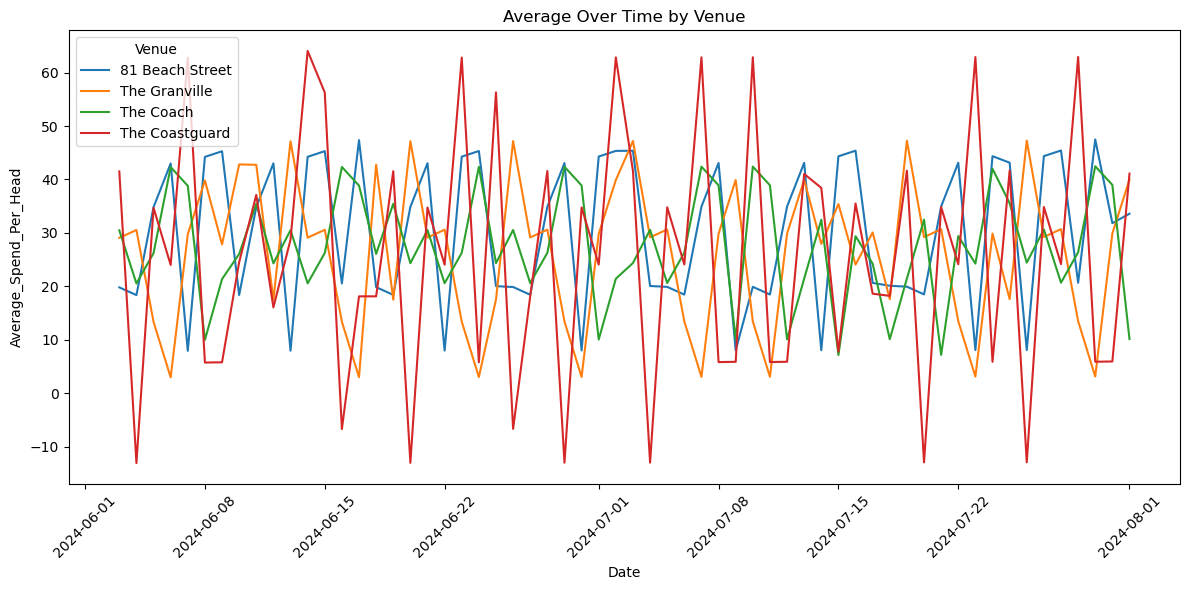

In [46]:
# Sélectionner les colonnes nécessaires et convertir en DataFrame Pandas
average_Spend_Per_Head_data = merged_tableFutur.select("Date", "venue", "Average_Spend_Per_Head").toPandas()

# Convertir la colonne 'Date' en type datetime
average_Spend_Per_Head_data['Date'] = pd.to_datetime(average_Spend_Per_Head_data['Date'])

# Tracer Net_Sales en fonction de la Date
plt.figure(figsize=(12, 6))
for venue in average_Spend_Per_Head_data['venue'].unique():
    venue_data = average_Spend_Per_Head_data[average_Spend_Per_Head_data['venue'] == venue]
    plt.plot(venue_data['Date'], venue_data['Average_Spend_Per_Head'], label=venue)

plt.xlabel('Date')
plt.ylabel('Average_Spend_Per_Head')
plt.title('Average Over Time by Venue')
plt.legend(title='Venue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 49, Finished, Available, Finished)

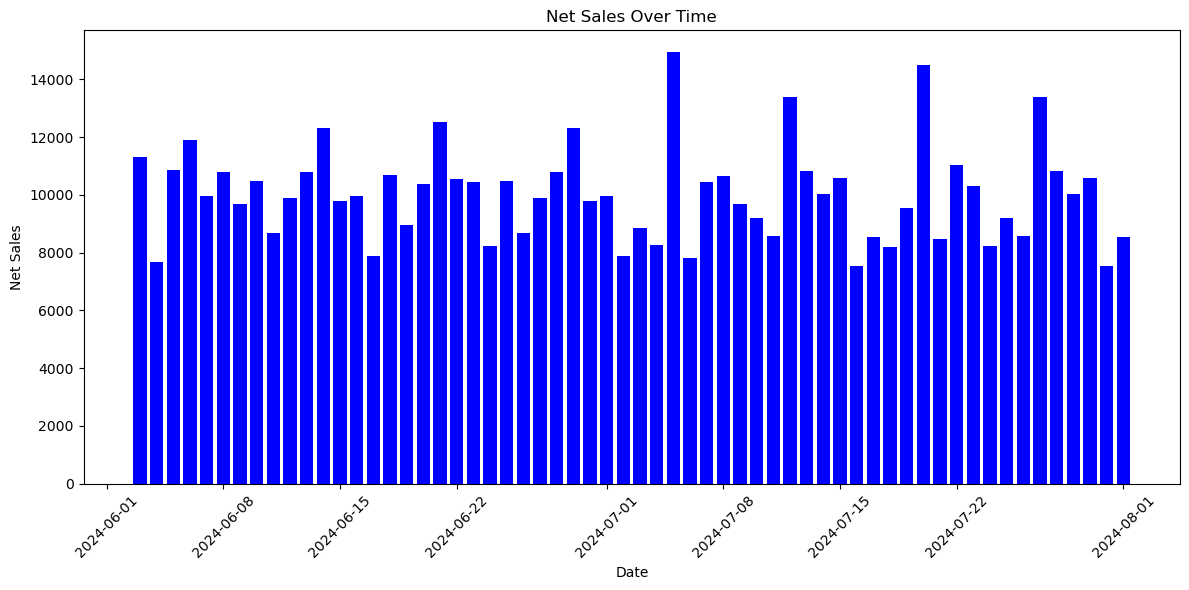

In [47]:
import matplotlib.pyplot as plt

# Créer une colonne de date sans heure pour le regroupement
net_sales_data['DateOnly'] = net_sales_data['Date'].dt.date

# Regrouper les données par Date et calculer la somme des ventes nettes
grouped_data = net_sales_data.groupby('DateOnly')['Net_Sales'].sum().reset_index()

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
plt.bar(grouped_data['DateOnly'], grouped_data['Net_Sales'], color='blue')

plt.xlabel('Date')
plt.ylabel('Net Sales')
plt.title('Net Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 50, Finished, Available, Finished)

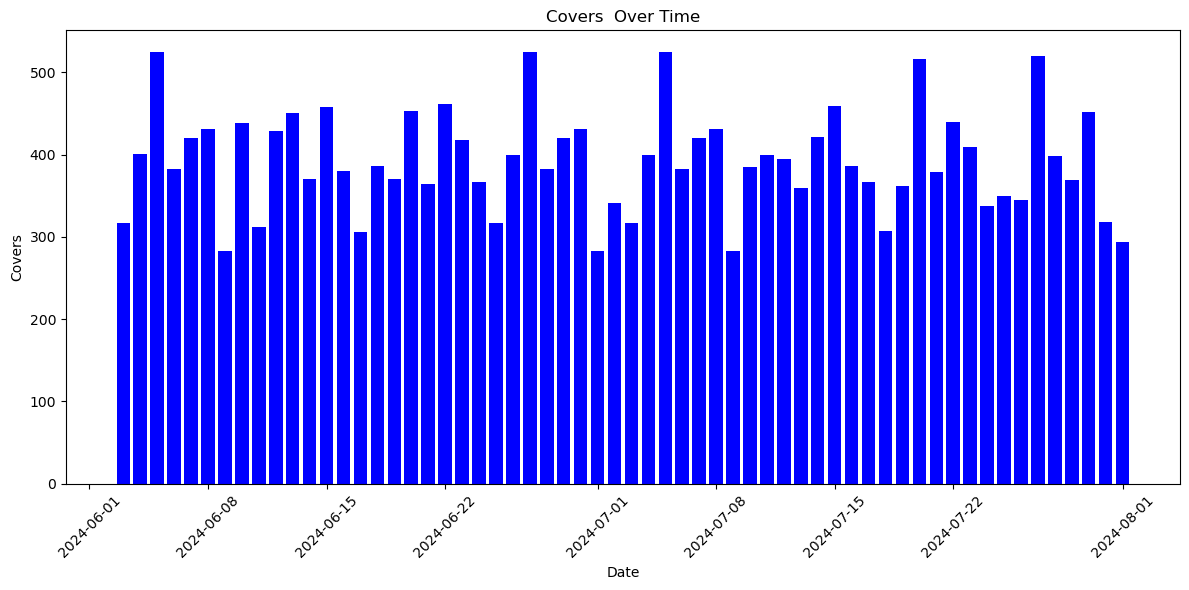

In [48]:
import matplotlib.pyplot as plt

# Créer une colonne de date sans heure pour le regroupement
covers_data['DateOnly'] = covers_data['Date'].dt.date

# Regrouper les données par Date et calculer la somme des ventes nettes
grouped_covers_data = covers_data.groupby('DateOnly')['Covers'].sum().reset_index()

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
plt.bar(grouped_covers_data['DateOnly'], grouped_covers_data['Covers'], color='blue')

plt.xlabel('Date')
plt.ylabel('Covers')
plt.title('Covers  Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


StatementMeta(, 6265e3d0-b621-472e-b054-91951d545e14, 54, Finished, Available, Finished)

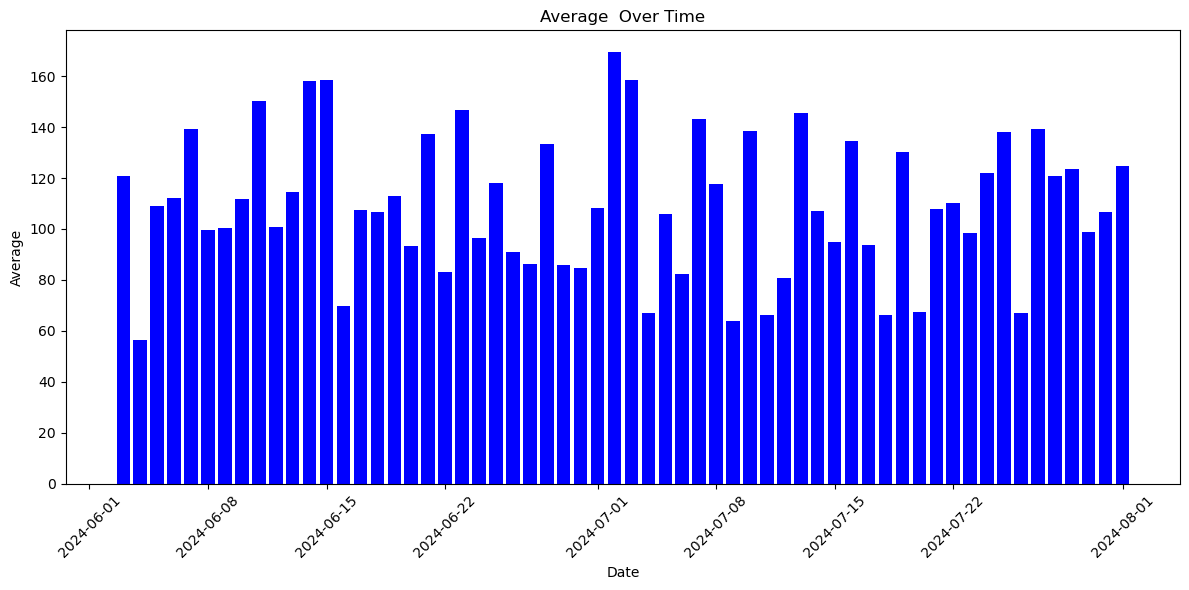

In [52]:
import matplotlib.pyplot as plt

# Créer une colonne de date sans heure pour le regroupement
average_Spend_Per_Head_data['DateOnly'] = average_Spend_Per_Head_data['Date'].dt.date

# Regrouper les données par Date et calculer la somme des ventes nettes
grouped_average_Spend_Per_Head_data = average_Spend_Per_Head_data.groupby('DateOnly')['Average_Spend_Per_Head'].sum().reset_index()

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
plt.bar(grouped_average_Spend_Per_Head_data['DateOnly'], grouped_average_Spend_Per_Head_data['Average_Spend_Per_Head'], color='blue')

plt.xlabel('Date')
plt.ylabel('Average')
plt.title('Average  Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()